<a href="https://colab.research.google.com/github/nse-yu/colab-ML/blob/main/human_faces_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import json

## データのロード

In [9]:
faces_info = pd.read_json("/content/drive/MyDrive/data/json/project_face_json.json")

> jsonファイルはデータフレームで受け取る

In [10]:
print(type(faces_info))

<class 'pandas.core.frame.DataFrame'>


> 確認

In [11]:
paths = ["/content/imgs_deep/" + faces_info[key]["filename"] for key in faces_info.keys()]
regions = [faces_info[key]["regions"] for key in faces_info.keys()]
info = [dict({"path":path},**attrs[0]["region_attributes"],**attrs[0]["shape_attributes"]) for path,attrs in zip(paths,regions)]
print(info)

[{'path': '/content/imgs_deep/Aaron_Eckhart_0001.jpg', 'tag': 'face\n', 'name': 'ellipse', 'cx': 123, 'cy': 114, 'rx': 50, 'ry': 75, 'theta': 0}, {'path': '/content/imgs_deep/Aaron_Guiel_0001.jpg', 'tag': 'face', 'name': 'ellipse', 'cx': 117, 'cy': 124, 'rx': 55, 'ry': 71, 'theta': 0}, {'path': '/content/imgs_deep/Aaron_Patterson_0001.jpg', 'tag': 'face', 'name': 'ellipse', 'cx': 131, 'cy': 119, 'rx': 50, 'ry': 70, 'theta': 0}, {'path': '/content/imgs_deep/Aaron_Peirsol_0001.jpg', 'tag': 'face', 'name': 'ellipse', 'cx': 120, 'cy': 111, 'rx': 54, 'ry': 78, 'theta': 0}, {'path': '/content/imgs_deep/Aaron_Peirsol_0002.jpg', 'tag': 'face', 'name': 'ellipse', 'cx': 121, 'cy': 123, 'rx': 50, 'ry': 70, 'theta': 0}, {'path': '/content/imgs_deep/Aaron_Peirsol_0003.jpg', 'tag': 'face', 'name': 'ellipse', 'cx': 125, 'cy': 117, 'rx': 53, 'ry': 72, 'theta': 0}, {'path': '/content/imgs_deep/Aaron_Peirsol_0004.jpg', 'tag': 'face', 'name': 'ellipse', 'cx': 133, 'cy': 117, 'rx': 44, 'ry': 72, 'theta': 

> zipファイルの解凍

In [ ]:
!cp "/content/drive/MyDrive/data/compressed/imgs_deep.zip" .
!unzip imgs_deep.zip

In [15]:
print(info[0])

{'path': '/content/imgs_deep/Aaron_Eckhart_0001.jpg', 'tag': 'face\n', 'name': 'ellipse', 'cx': 123, 'cy': 114, 'rx': 50, 'ry': 75, 'theta': 0}


## util methods

In [139]:
def imget(paths,img_size=(32,32),data_type="float64"):
  """
  画像のpathリストを指定し、その画像をリストで返す。

  Parameters
  ---------------------------
  paths : list
      画像のパスを示す文字列を格納したリスト
  img_size : tuple
      画像のリサイズを指定
  data_type : str
      画像のデータタイプを指定
  """

  #データセットを格納する変数
  x_train = []
  
  #単一パスでもiterableにする
  if type(paths) == str:
    paths = [paths]

  #個別のFilePathに対して処理していきます。
  for p in paths:
    pathEach = p
    print(pathEach)

    img_before = cv2.imread(pathEach)
    #画像読み込みエラー時は次のエントリへ
    if img_before is None:
      continue
    print(img_before.shape)
    img_after = cv2.resize(img_before, dsize=img_size)
    img_after = cv2.cvtColor(img_after,cv2.COLOR_BGR2RGB)
    img_after = img_after.astype(data_type) / 255

    x_train.append(img_after)
  return np.array(x_train)

In [133]:
def toImgProcessed(img):
  """
  前処理として、以下を順に行う。
  １．RGBへの変換
  ２．型をfloat64へ変換
  ３．0～1へスケーリング

  Parameters
  -------------------------------
  img : list
      画像のピクセルが入ったリスト
  """
  p_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  p_img = p_img.astype("float64") / 255.0
  return p_img

In [155]:
def toImgFramed(img_info={},only_process=False,preview=True):
  """
  dictionaly（キーは対応するものでないとエラー）を受け取り、前処理、フレーム付与をしたものを画像オブジェクトとして返す。

  Parameters
  ---------------
  img_info : dict
      画像パスや位置情報が入った辞書
      少なくとも、path,cx,cy,rx,ryが必要です。
  only_process : boolean
      前処理のみ行うか
  preview : boolean
      処理後の画像を表示するか
  """

  #辞書型のみを処理するため
  if type(img_info) != dict:
    print("please pass arguments type of dict.")
    return

  img = cv2.imread(img_info["path"])
  processed_img = toImgProcessed(img)

  #前処理のみなら、ここで打ち止め
  if only_process == True:
    return processed_img

  #3px,red,楕円
  circled_img = cv2.ellipse(
      processed_img,
      box=((img_info["cx"],img_info["cy"]),(img_info["rx"]*2,img_info["ry"]*2),0),
      color=(255,0,0),
      thickness=3)
  
  #プレビューなし
  if preview == False:
    return circled_img

  #最終的な画像をプレビュー
  plt.imshow(circled_img)
  plt.show()
  
  return circled_img

In [136]:
def getBoxProps(info):
  """
  box情報のみを辞書から抽出するのために使用

  Parameters
  ---------------------------
  info : dict
      画像パスや位置情報が入った辞書
  """

  return np.array([[i["cx"],i["cy"],i["rx"],i["ry"]] for i in info])

In [197]:
def compareTo(imgs,info,end=1,compared=True):
  """
  フレーム付きデータの上に、予測データによる楕円フレームを重ねて表示

  Parameters
  -------------------------------
  imgs : list
      リサイズ後（imget後）の画像（元データ）
      楕円フレームを予測するのに使用
  info : dict
      画像パスや位置情報が入った辞書
      少なくとも、path,cx,cy,rx,ryが必要です。
  end : integer
      画像表示の上限
  compared : boolean
      比較対象がない場合にFalseにする
      その場合のみ、infoにはpathのみでよい
  """
  #スライスできないものは処理しない
  if end < 1:
    return
  if type(info) != list:
    info = [info]

  for test_img,i in zip(imgs[:end],info[:end]):

    #フレーム付き
    framed_img = toImgFramed(i,preview=False) if compared == True else toImgFramed(i,only_process=True,preview=False)
    #フレーム無し
    pred = model.predict(np.array([test_img]))[0]
    print("------------------------------------------------------------")
    print("predicted box |=====> ",pred)
    print("------------------------------------------------------------")

    circled_img = cv2.ellipse(framed_img,box=((pred[0],pred[1]),(pred[2]*2,pred[3]*2),0),color=(0,255,0),thickness=3)
    plt.imshow(circled_img)
    plt.show()

## 抽出

> フレーム付きで画像を出力

In [ ]:
for i in info[:5]:
  toImgFramed(i)

> データセットの抽出

In [ ]:
paths = [i["path"] for i in info]

imgs = imget(paths)
boxes = getBoxProps(info)

In [ ]:
print(boxes)

## モデルの訓練

In [22]:
from tensorflow import keras 

> モデル定義

In [26]:
base_model = keras.applications.xception.Xception(weights="imagenet",include_top=False)

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
loc_output = keras.layers.Dense(4)(avg)

model = keras.Model(inputs=base_model.input,outputs=[loc_output])

In [ ]:
model.summary()

> モデルコンパイル

In [36]:
model.compile(
    loss="mse",
    optimizer="sgd",
    metrics=["accuracy"]
)

> モデルの訓練

In [ ]:
history = model.fit(x=imgs,y=boxes,epochs=60,validation_split=0.1)

> 予測

In [ ]:
paths = [i["path"] for i in info]
imgs = imget(paths)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------
predicted box |=====>  [128.63103  124.341125  50.43672   73.114334]
------------------------------------------------------------


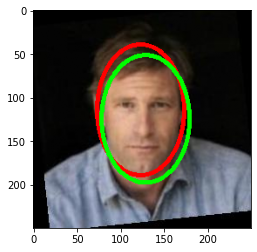

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------
predicted box |=====>  [125.21521  130.24165   48.892345  67.12262 ]
------------------------------------------------------------


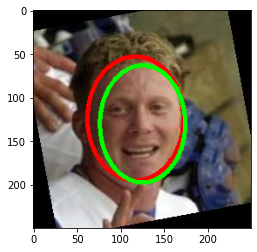

In [198]:
compareTo(imgs,info,2)

> 未知データ

In [192]:
new_img = imget("/content/Yao_Ming_0005.jpg")
print(new_img.shape)

/content/Yao_Ming_0005.jpg
(250, 250, 3)
(1, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------
predicted box |=====>  [127.54309  128.2249    48.267715  68.11103 ]
------------------------------------------------------------


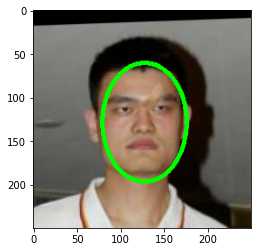

In [199]:
new_info = {"path":"/content/Yao_Ming_0005.jpg"}
compareTo(new_img,new_info,compared=False)